In [1]:
from initialization import Location
from initialization import Grid
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mpl_ptoolkits.mpplot3d import Axes3D

# Base Model

In [2]:

# Parameters
beta = 0.3 
mu = 0.1
population = 1000 
initial_infected = 1  
initial_susceptible = population - initial_infected  
initial_recovered = 0 
days = 100  

# Create arrays to store the results
susceptible = np.zeros(days)
infectious = np.zeros(days)
recovered = np.zeros(days)

# Initialize the initial conditions
susceptible[0] = initial_susceptible
infectious[0] = initial_infected
recovered[0] = initial_recovered

# Simulate the SIR model
for day in range(1, days):
    new_infections = beta * susceptible[day - 1] * infectious[day - 1] / population
    new_recoveries = mu * infectious[day - 1]

    susceptible[day] = susceptible[day - 1] - new_infections
    infectious[day] = infectious[day - 1] + new_infections - new_recoveries
    recovered[day] = recovered[day - 1] + new_recoveries



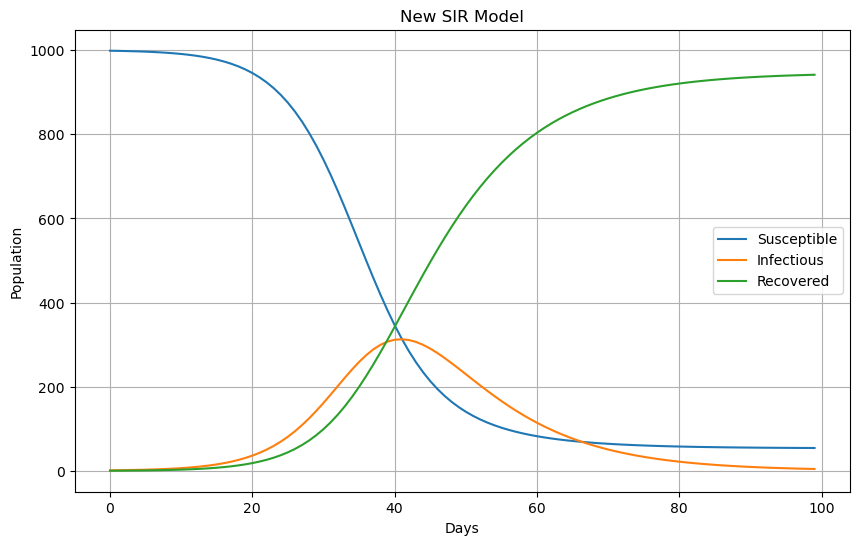

In [3]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(susceptible, label="Susceptible")
plt.plot(infectious, label="Infectious")
plt.plot(recovered, label="Recovered")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.title("New SIR Model")
plt.grid(True)
plt.show()

# Mobility-Based Model

In [4]:

def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

### Random Origin w/ Dynamic Alpha

In [39]:
from initialization import Location
from initialization import Grid
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mpl_ptoolkits.mpplot3d import Axes3D

def dynamic_alpha_connectivity():
    # Parameters
    beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
    mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
    N = 100000
    n_locations=100
    days = 100
    alphas = np.arange(0,1.05,0.05)
    outside_connectivity = np.arange(0,1.05,0.05)
    trials=1

    alpha_connectivity_sir = {}

    for alpha in alphas:
        for c in outside_connectivity:

            for trial in range(trials):
                alpha_connectivity_sir[(alpha,c)] = []
                # Create arrays to store the results
                infectious = np.zeros(days)
                #Initialize grid and locations
                grid = Grid(n_locations, N, alpha, beta, mu, c)

                #initialize random starting location
                grid.random_orgin()
                day = 0
                for day in range(days):
                    for loc in grid.map:
                        if loc.n != 0:
                            infections, total_connections = get_other_loc_params(grid, loc)
                            
                            new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                            
                            new_recoveries = (mu * loc.i) / loc.n

                            loc.s = loc.s - new_infections
                            loc.i = loc.i + new_infections - new_recoveries
                            loc.r = loc.r + new_recoveries

                            infectious[day] += loc.i
                    if infectious[day] < infectious[day-1] and day > 0:
                        alpha_connectivity_sir[(alpha,c)].append(day-1)
                        break
                if len(alpha_connectivity_sir[(alpha,c)]) == 0:
                    alpha_connectivity_sir[(alpha,c)].append(day)

            alpha_connectivity_sir[(alpha,c)] = np.mean(alpha_connectivity_sir[(alpha,c)])

    return alpha_connectivity_sir
    

(21, 21)


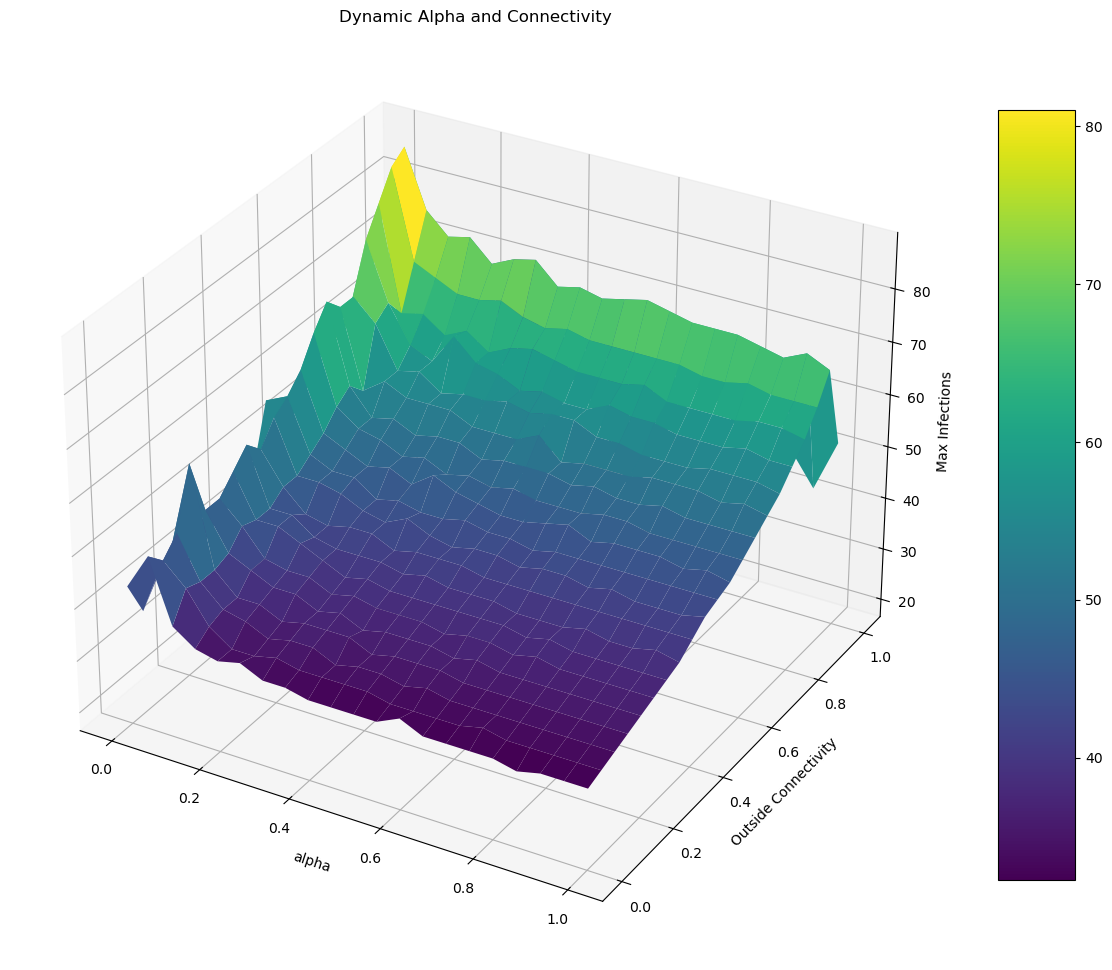

In [42]:
x = np.arange(0,1.05,0.05)
y = np.arange(0,1.05,0.05)[::-1]
x, y = np.meshgrid(x, y)
dictionary = dynamic_alpha_connectivity()
values = list(dictionary.values())
z = []

for i in range(len(np.arange(0,1.05,0.05))):
    miniList = []
    for j in range(len(np.arange(0,1.05,0.05))):
        miniList.append(values.pop(0))
    z.append(miniList)
z = np.array(z)
print(z.shape)

fig = plt.figure(figsize = (15, 20))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z, cmap='viridis')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('alpha')
ax.set_ylabel('Outside Connectivity')
ax.set_zlabel('Max Infections')

ax.set_title("Dynamic Alpha and Connectivity")

plt.show()

In [32]:
def dynamic_alpha():
    # Parameters
    beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
    mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
    N = 100000
    n_locations=100
    days = 100
    alphas = np.arange(0.1,1.1,0.1)
    alpha=0.5
    trials=10

    alpha_sir = {}
    for alpha in alphas:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            #Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            #initialize random starting location
            grid.random_orgin()

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) / loc.n

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir

In [24]:
dynamic_alpha_results = dynamic_alpha()
dynamic_alpha_results

{0.1: [[1,
   0.9999986678302772,
   0.9999982254769092,
   0.9999976364545841,
   0.9999968522317695,
   0.9999958082746865,
   0.9999944188052865,
   0.9999925698632641,
   0.9999901101359918,
   0.9999868388574541,
   0.9999824898676927,
   0.9999767106540725,
   0.9999690348455167,
   0.9999588461712765,
   0.9999453312804101,
   0.9999274179755077,
   0.9999036942409608,
   0.999872301817949,
   0.9998307959003636,
   0.9997759598405804,
   0.9997035608842719,
   0.9996080305322519,
   0.999482051814533,
   0.9993160356342697,
   0.9990974685193533,
   0.9988101133850896,
   0.9984330429497312,
   0.997939482915435,
   0.9972954384384187,
   0.9964580686356485,
   0.9953737519726024,
   0.9939757411542356,
   0.992181232974581,
   0.9898875764918554,
   0.9869672242809029,
   0.9832609323432433,
   0.9785687098775415,
   0.9726382289958582,
   0.9651509567733374,
   0.955707247634438,
   0.9438130107765298,
   0.9288722111565977,
   0.9101911367377037,
   0.8870016871581163,
   0.

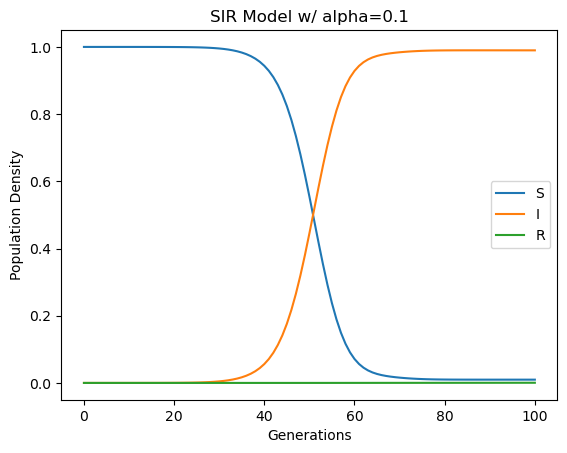

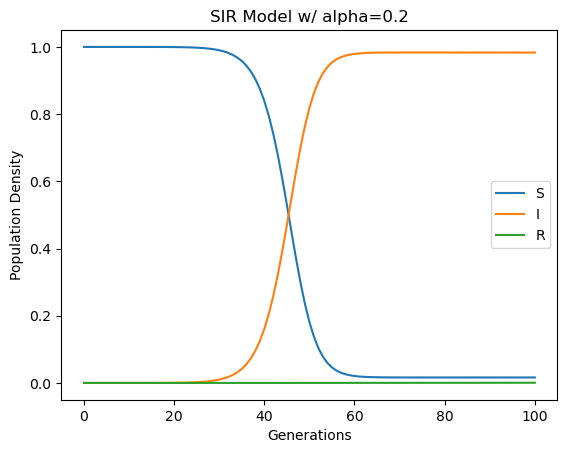

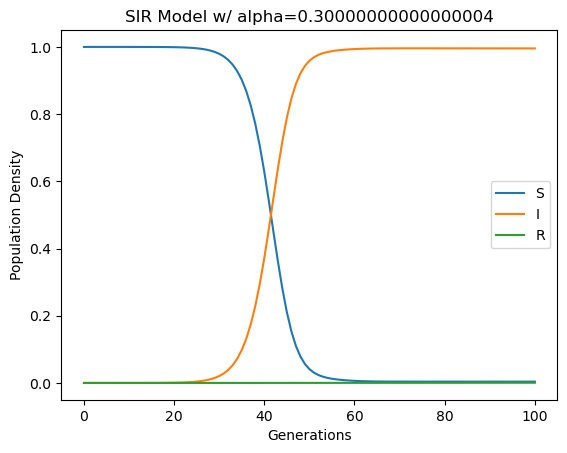

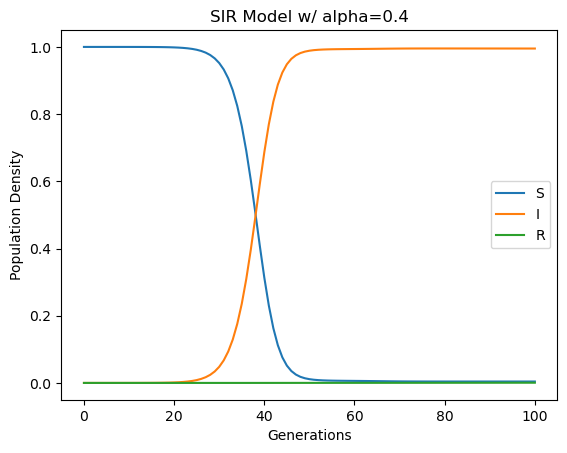

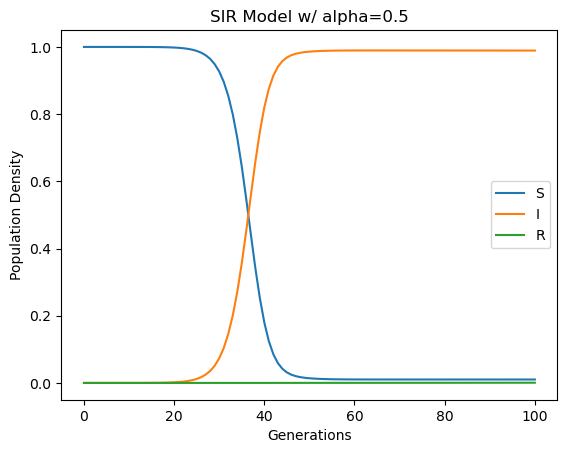

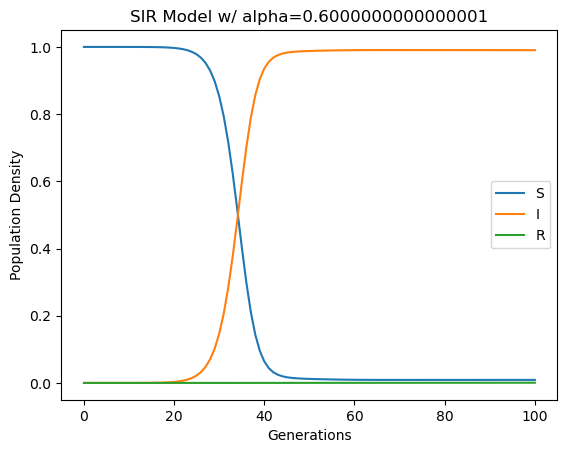

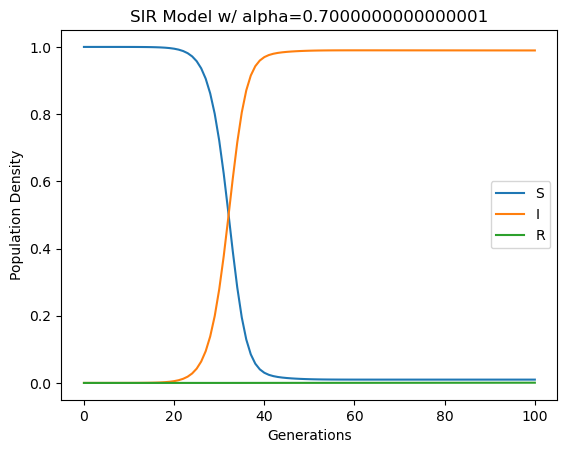

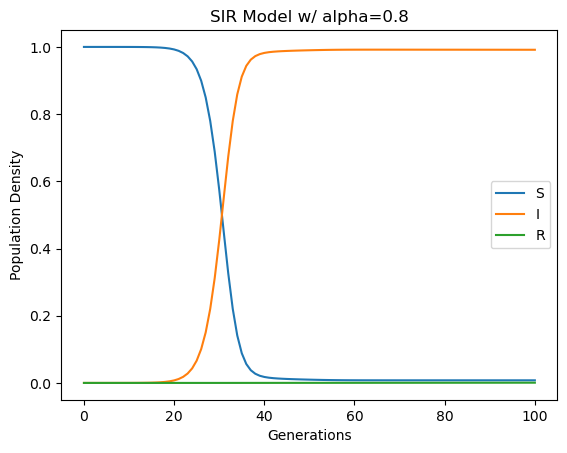

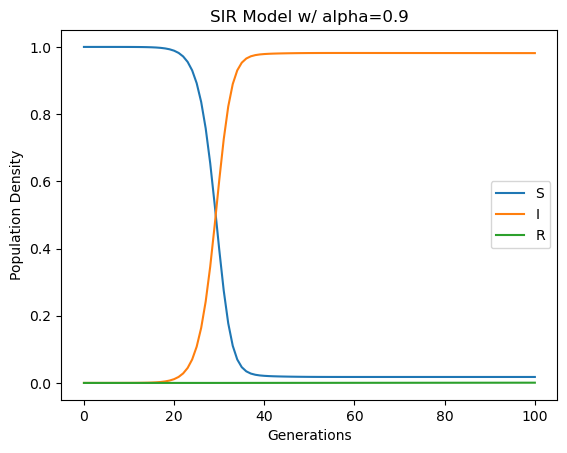

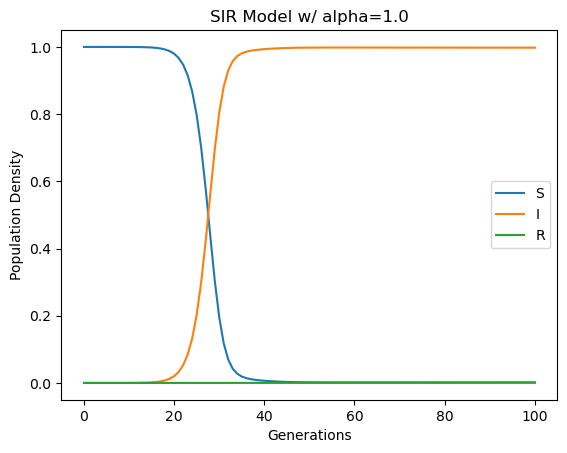

In [33]:
translation = {0:"S", 1:"I", 2:"R"}
for key, values in dynamic_alpha_results.items():
    plt.figure()
    for sublist in values:
        # plt.plot(sublist, label=f'{key}_{values.index(sublist)}')
        plt.plot(sublist, label=translation[values.index(sublist)])
        plt.title(f'SIR Model w/ alpha={key}')

    plt.legend()
    plt.xlabel("Generations")
    plt.ylabel("Population Density")
    
plt.show()

# Mobility Based SIR Models - Random, High, and Low

In [9]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials):
    alpha_sir = {}
    for alpha in alpha_range:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High Mobility":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)
                

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) / loc.n

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir

In [10]:
def sir_plotting(results, type):
    for key, values in results:
        plt.figure()
        for sublist in values:
            # plt.plot(sublist, label=f'{key}_{values.index(sublist)}')
            plt.plot(sublist, label=translation[values.index(sublist)])
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {key}')

        plt.legend()
        plt.xlabel("Generations")
        plt.ylabel("Population Density")
    plt.show()

### SIR Model with Random Origin and Dynamic Alpha

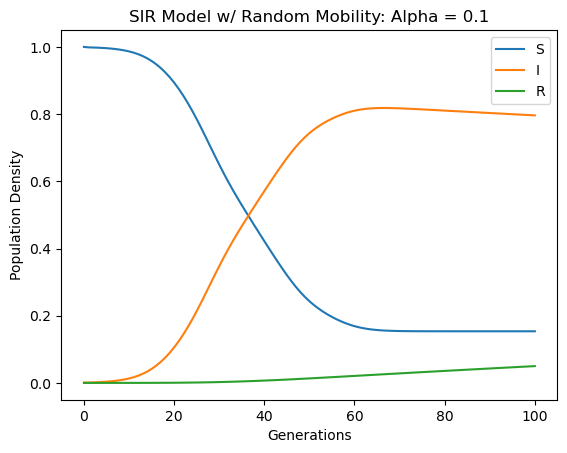

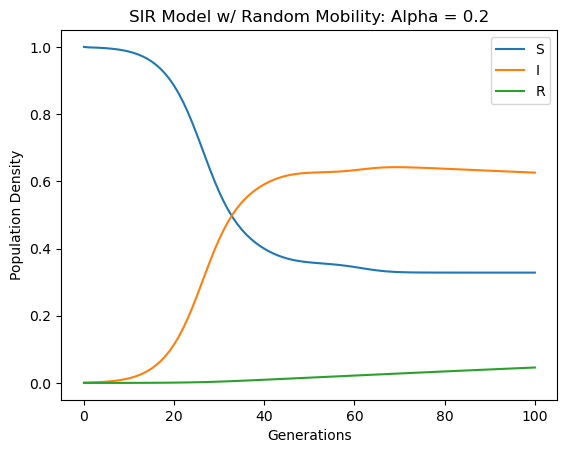

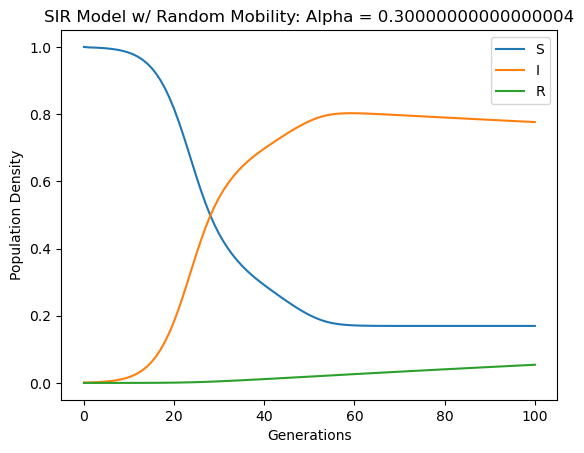

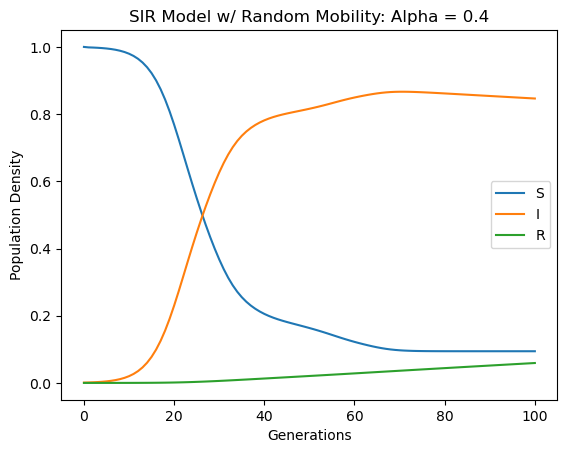

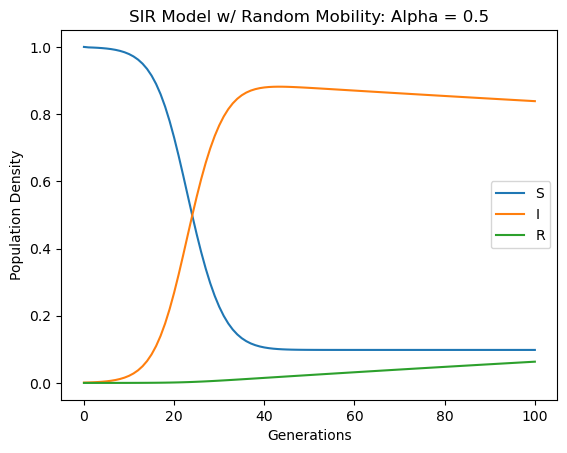

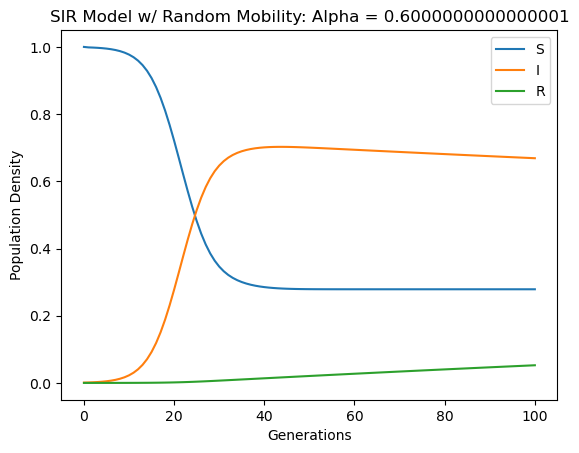

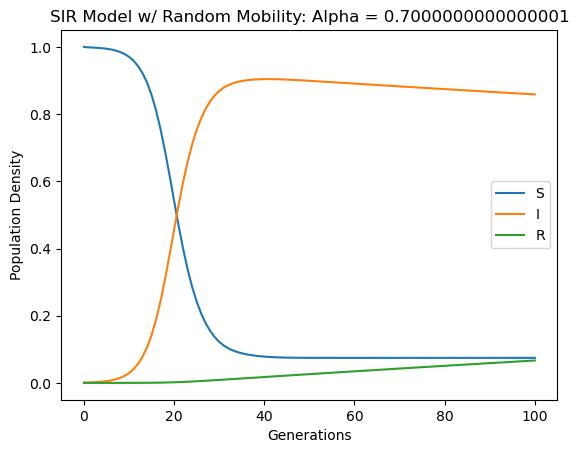

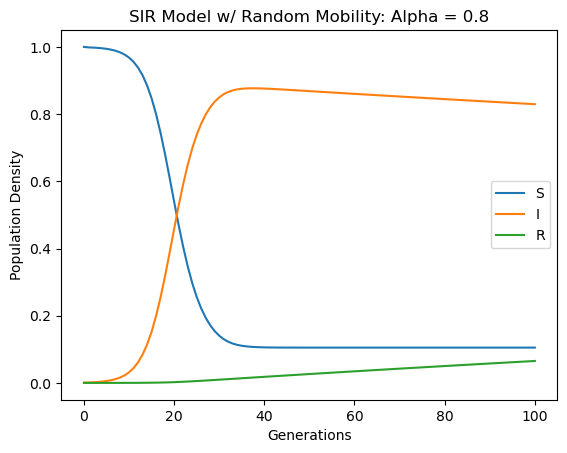

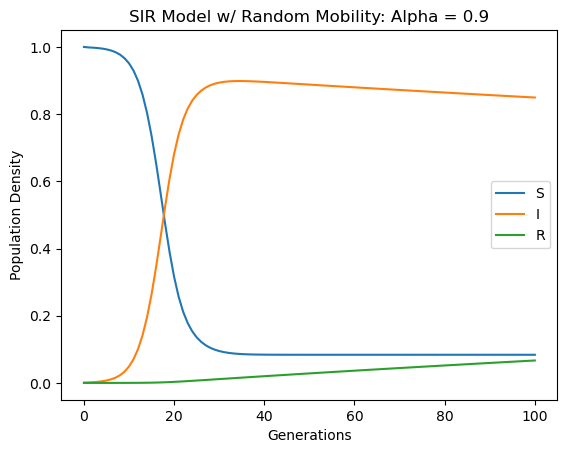

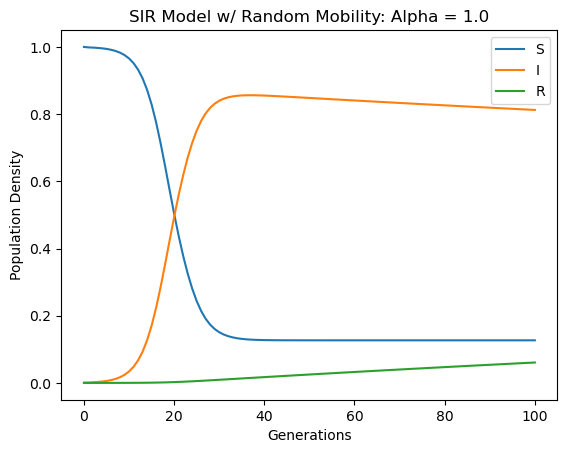

In [11]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
N = 1000 
n_locations=10
days = 100
alphas = np.arange(0.1,1.1,0.1)
trials=10

type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
sir_plotting(dynamic_alpha_results.items(), type)


### SIR Model with High Mobility and Dynamic Alpha

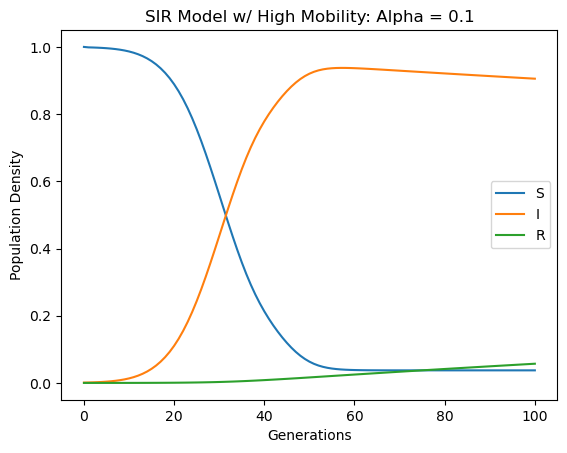

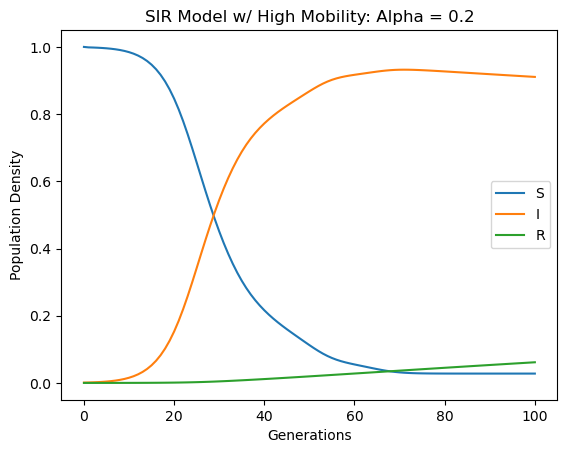

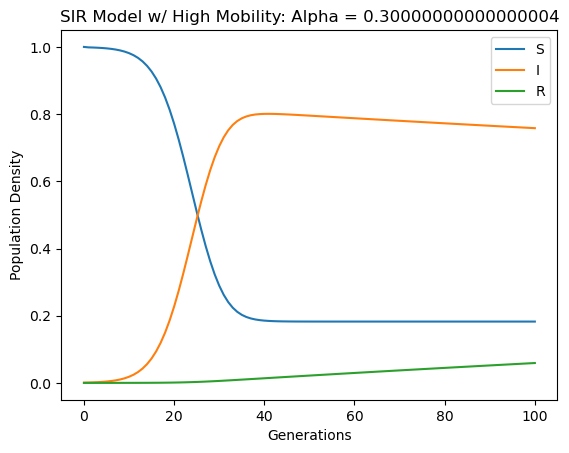

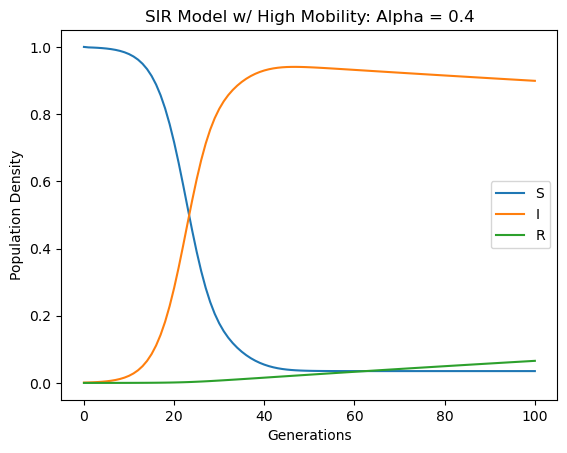

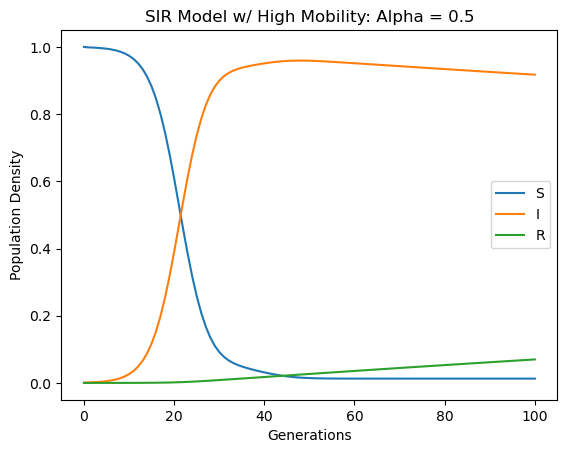

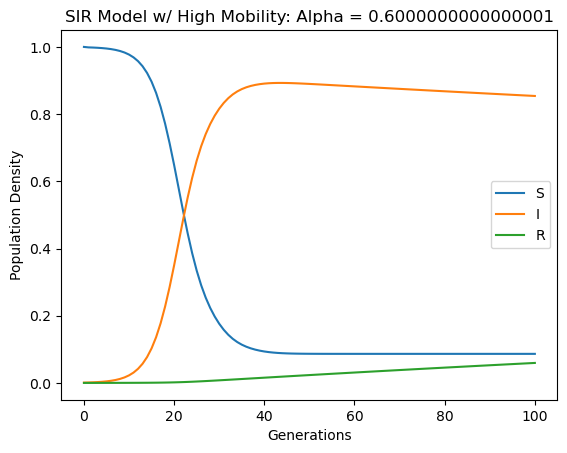

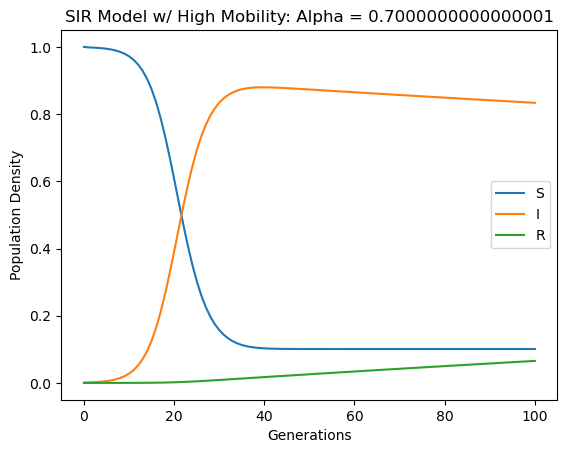

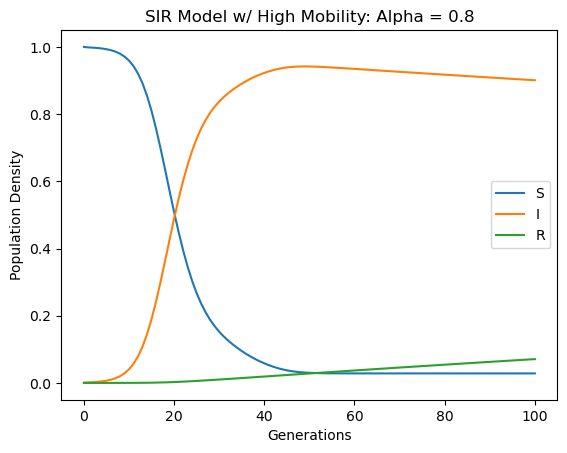

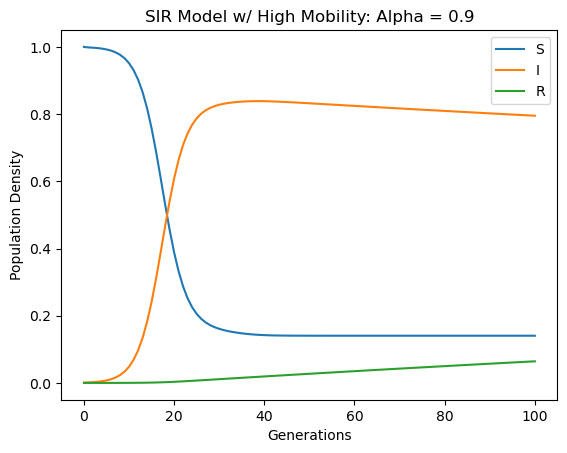

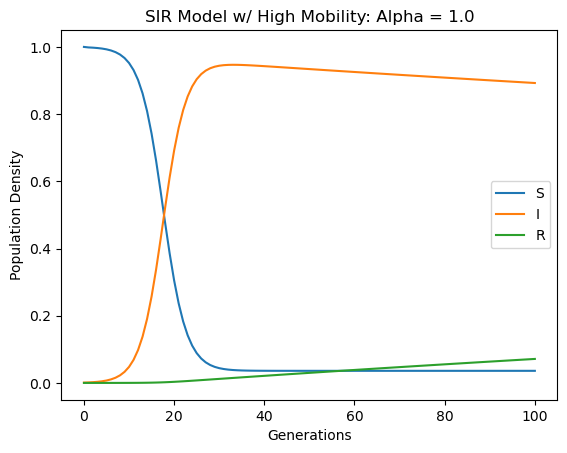

In [12]:
type = "High"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results.items(), type)


### SIR Model with Low Mobility and Dynamic Alpha

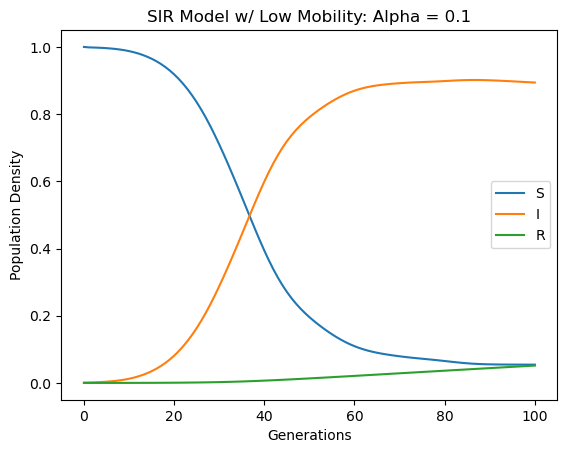

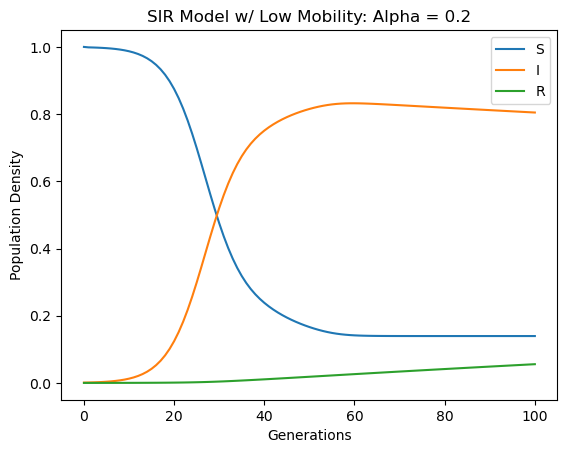

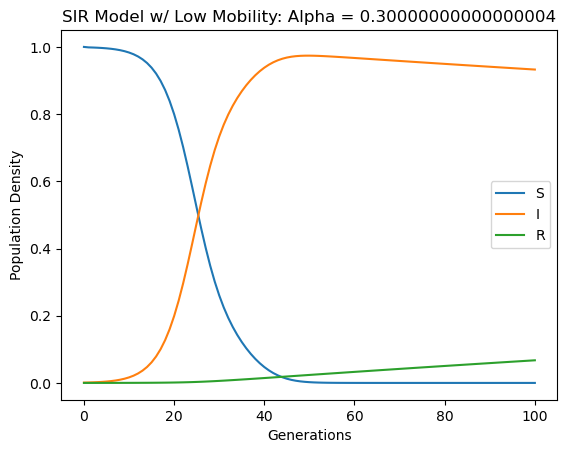

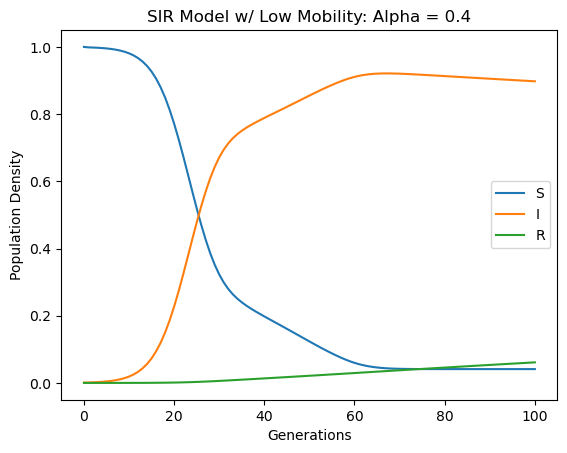

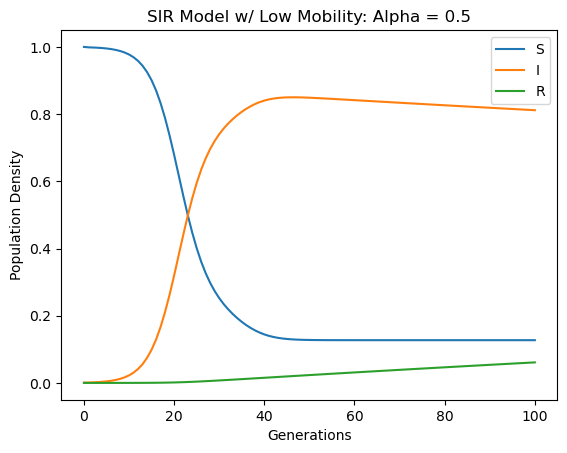

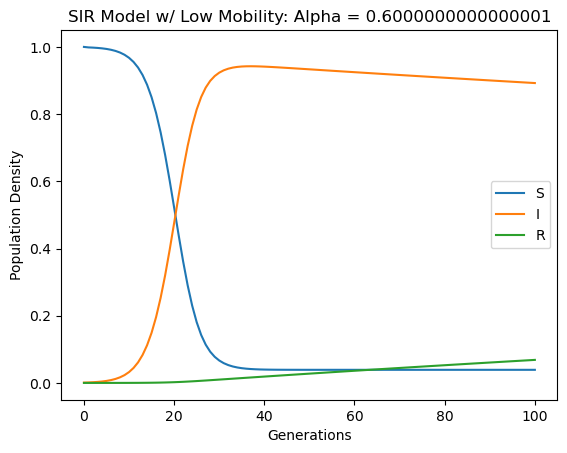

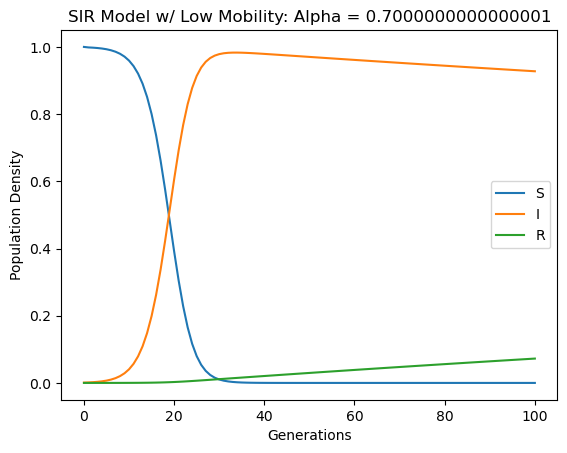

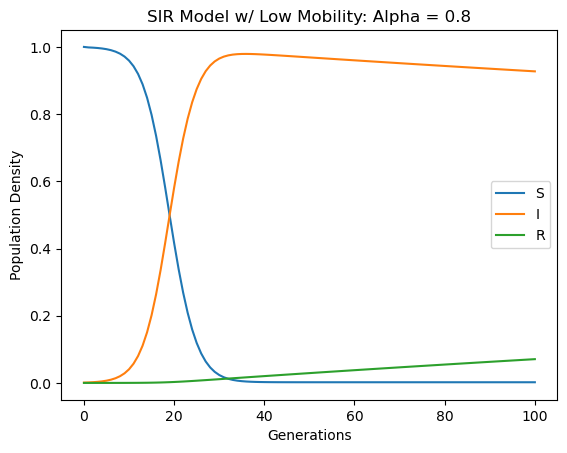

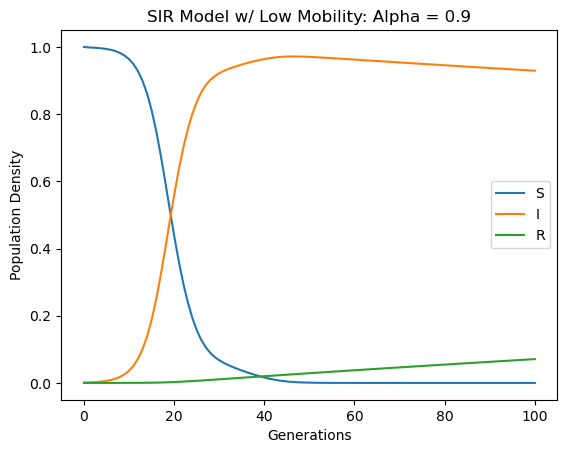

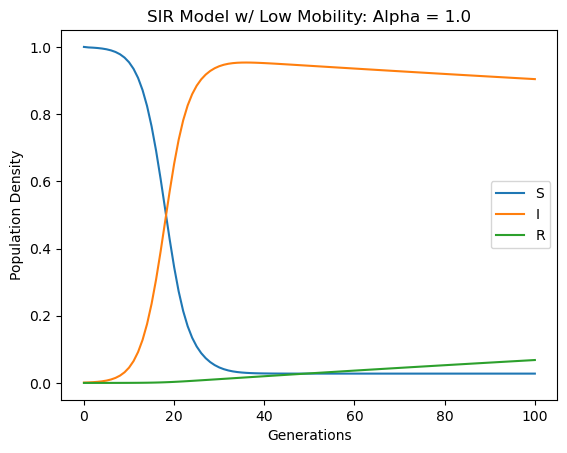

In [13]:
type = "Low"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results.items(), type)